# Create Climate Network of monthly 2m temperature from ERA5


In [1]:
import numpy as np
from climnet.dataset import AnomalyDataset
import climnet.network.net as net
import climnet.network.clim_networkx as nx
from climnet.utils import time_utils
import climnet.plots as cplt
from importlib import reload

# Set parameters and paths
datapath = '../../data/t2m/2m_temperature_monthly_1979_2020.nc'
datapath = '/home/strnad/data/era5/2m_temperature/2m_temperature_sfc_1979_2020_mon_mean.nc'

### Regridding of data to an equidistant grid
The data is interpolated to an (approximately) uniformly spaced Fekete Grid.

The dataset class will also create anomaly time series of the input time series with respect to day of year.

Moreover, the data is detrended.

In [2]:
ds = AnomalyDataset(data_nc=datapath,
                    var_name='t2m',
                    grid_step=10,
                    grid_type='fekete', 
                    detrend=True, 
                    climatology="dayofyear")


['time', 'longitude', 'latitude']
Rename:longitude : lon 
['time', 'lon', 'latitude']
['time', 'lon', 'latitude']
Rename:latitude : lat 
['time', 'lon', 'lat']
Shift longitude!
Start create grid fekete...

Create Fekete grid with 367 points with 1000 iterations.
Initial configuration not provided. Generating random one ...


Estim 54%|████████████████▏             | 538/1000 [00:06<00:05, 89.10it/s] 

convergence reached after 538 iterations!
... Finished
Cut grid in range lat: [array(-90., dtype=float32), array(90., dtype=float32)] and lon: [array(-180., dtype=float32), array(179.75, dtype=float32)]
transpose data!


Interpolate data to new grid:
Detrending data...
... finished!
Compute anomalies for variable t2m.
Created dayofyearly anomalies!


### Create a network from the created dataset

Here we create a network based on spearman correlations where we create the network only for correlation values with highest/lowest correlation such that the density of the network is 2%.

In [5]:
reload(net)
Net = net.CorrClimNet(ds, corr_method='spearman',
                  density=0.02)
Net.create()

The number of non-zero datapoints 367 should approx. be 367.
(492, 367)
Created spearman correlation matrix of shape (367, 367)
Created spearman correlation matrix of shape (367, 367)
Minimum Correlation values: 0.38823656369239895
Created adjacency matrix.


We remove spurious links using link bundling. This may take a while. Therefore, we suggest to store the network after that.

In [6]:
adjacency_lb = Net.link_bundles(
    num_rand_permutations=2000,
)
Net.save('../../outputs/t2m_fekete_net_lb.npz')

The number of non-zero datapoints 367 should approx. be 367.
Start computing null model of link bundles using None!
Save to folder: /home/strnad/climnet/public/climnet/climnet/network/link_bundles/anomalies/!
Not running with SLURM job arrays, but with manual id:  0
Number of available CPUs: 16 for link bundeling!
Number of different number of links 41.


100%|██████████| 41/41 [00:00<00:00, 200.99it/s]

No number of links!
No number of links!


Now compute new adjacency matrix!
Number of available CPUs: 16


100%|██████████| 367/367 [00:00<00:00, 1013.62it/s]


Warning File../../outputs/t2m_fekete_net_lb.npz already exists! No over writing!
Network stored to ../../outputs/t2m_fekete_net_lb.npz!


Currently, we create a networkx object from the computed network to store computed properties

In [7]:
reload(nx)
cnx = nx.Clim_NetworkX(dataset=ds,
                    network=Net,
                    weighted=True)

# Compute node degree
cnx.compute_network_attrs('degree')
# save network as networkx file
cnx.save(savepath='../../outputs/t2m_network.graphml')

WARNING! Removed isolated nodes from network! Frac: 0.1444
Update Dataset as well and remove unconnected nodes
No isolated nodes anymore!


100%|██████████| 314/314 [00:00<00:00, 3503.29it/s]

Finished setting edge corr values!
DiGraph with 314 nodes and 2376 edges
Sparsity of adjacency:  0.024098340703476814
Node attributes: ['lon', 'lat']
Edge attributes: ['weight']
Compute degree, weighted=False!
Create ds for all attributes present in node 0.
ClimNetworkx File saved to ../../outputs/t2m_network.graphml!


### Plot node degree

/home/strnad/anaconda3/envs/climnetenv/lib/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/strnad/anaconda3/envs/climnetenv/lib/python3.9/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/strnad/anaconda3/envs/climnetenv/lib/python3.9/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/home/strnad/anaconda3/en

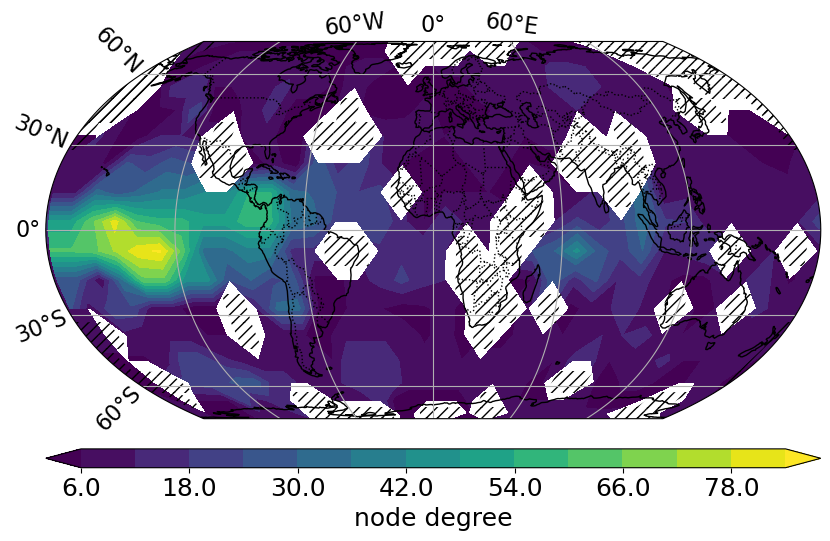

In [8]:
reload(cplt)
im = cplt.plot_map(cnx.ds,
                   cnx.ds_nx['degree'],
                   plot_type='contourf',
                   significant_mask=True,
                   projection='EqualEarth',
                   plt_grid=True,
                   levels=15,
                   tick_step=2,
                   round_dec=3,
                   label='node degree'
                   )
